In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf
keras.backend.set_floatx('float64')

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 100
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 50
LOSS = smape
FEATUERS_NUMBER = 4

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE)

# Train The Model

In [8]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
        output_size=HORIZON*FEATUERS_NUMBER, learning_rate=0.001, loss = LOSS, dropout_ratio = 0.3, features_number = FEATUERS_NUMBER)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/100
129/129 [==============================] - 15s 113ms/step - loss: 116.1531 - val_loss: 107.4965
Epoch 2/100
129/129 [==============================] - 13s 104ms/step - loss: 99.7382 - val_loss: 100.8309
Epoch 3/100
129/129 [==============================] - 14s 105ms/step - loss: 89.7800 - val_loss: 95.6367
Epoch 4/100
129/129 [==============================] - 14s 105ms/step - loss: 83.0405 - val_loss: 88.0261
Epoch 5/100
129/129 [==============================] - 14s 106ms/step - loss: 74.0847 - val_loss: 82.8319
Epoch 6/100
129/129 [==============================] - 13s 104ms/step - loss: 69.1605 - val_loss: 76.4992
Epoch 7/100
129/129 [==============================] - 14s 106ms/step - loss: 66.0447 - val_loss: 72.2913
Epoch 8/100
129/129 [==============================] - 14s 107ms/step - loss: 63.7535 - val_loss: 69.7439
Epoch 9/100
129/129 [==============================] - 14s 105ms/step - loss: 61.7893 - val_loss: 63.2939
Epoch 10/100
129/129 [=====================

# Save The Model

In [3]:
MODEL_BASE_DIR = '../models/with_lower_upper/3-LSTM'


In [9]:
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_lower_upper/3-LSTM/2


# Get Best And Worst Predictions

In [4]:
model = M4Model()
hyperparameters = model.load(f'{MODEL_BASE_DIR}/2')
    


Loaded model from disk


Best Predection Error is     6.7296
Worst Predection Error is   129.0486


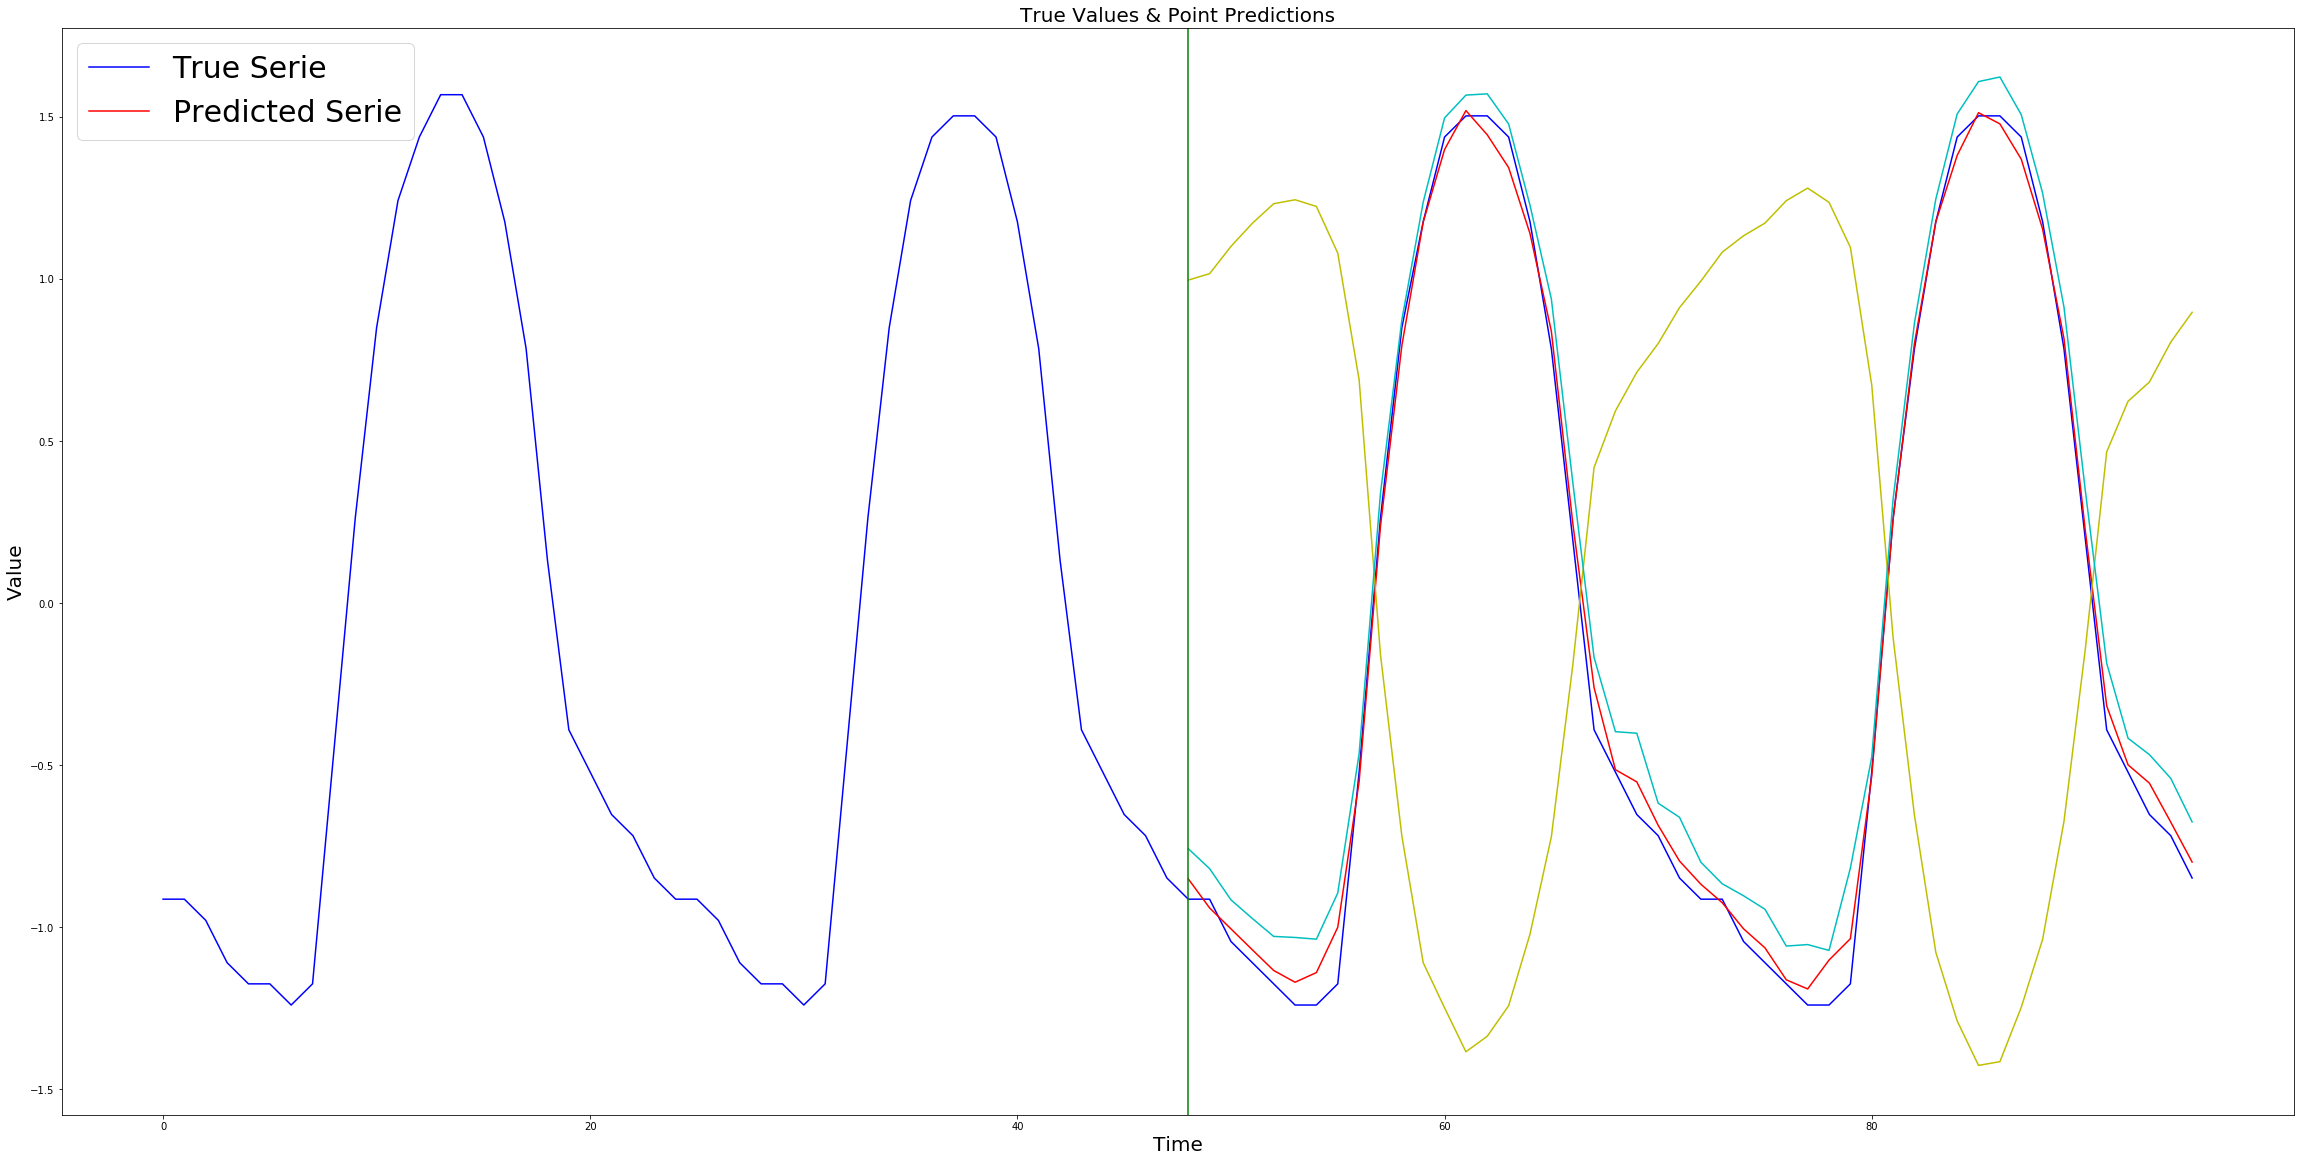

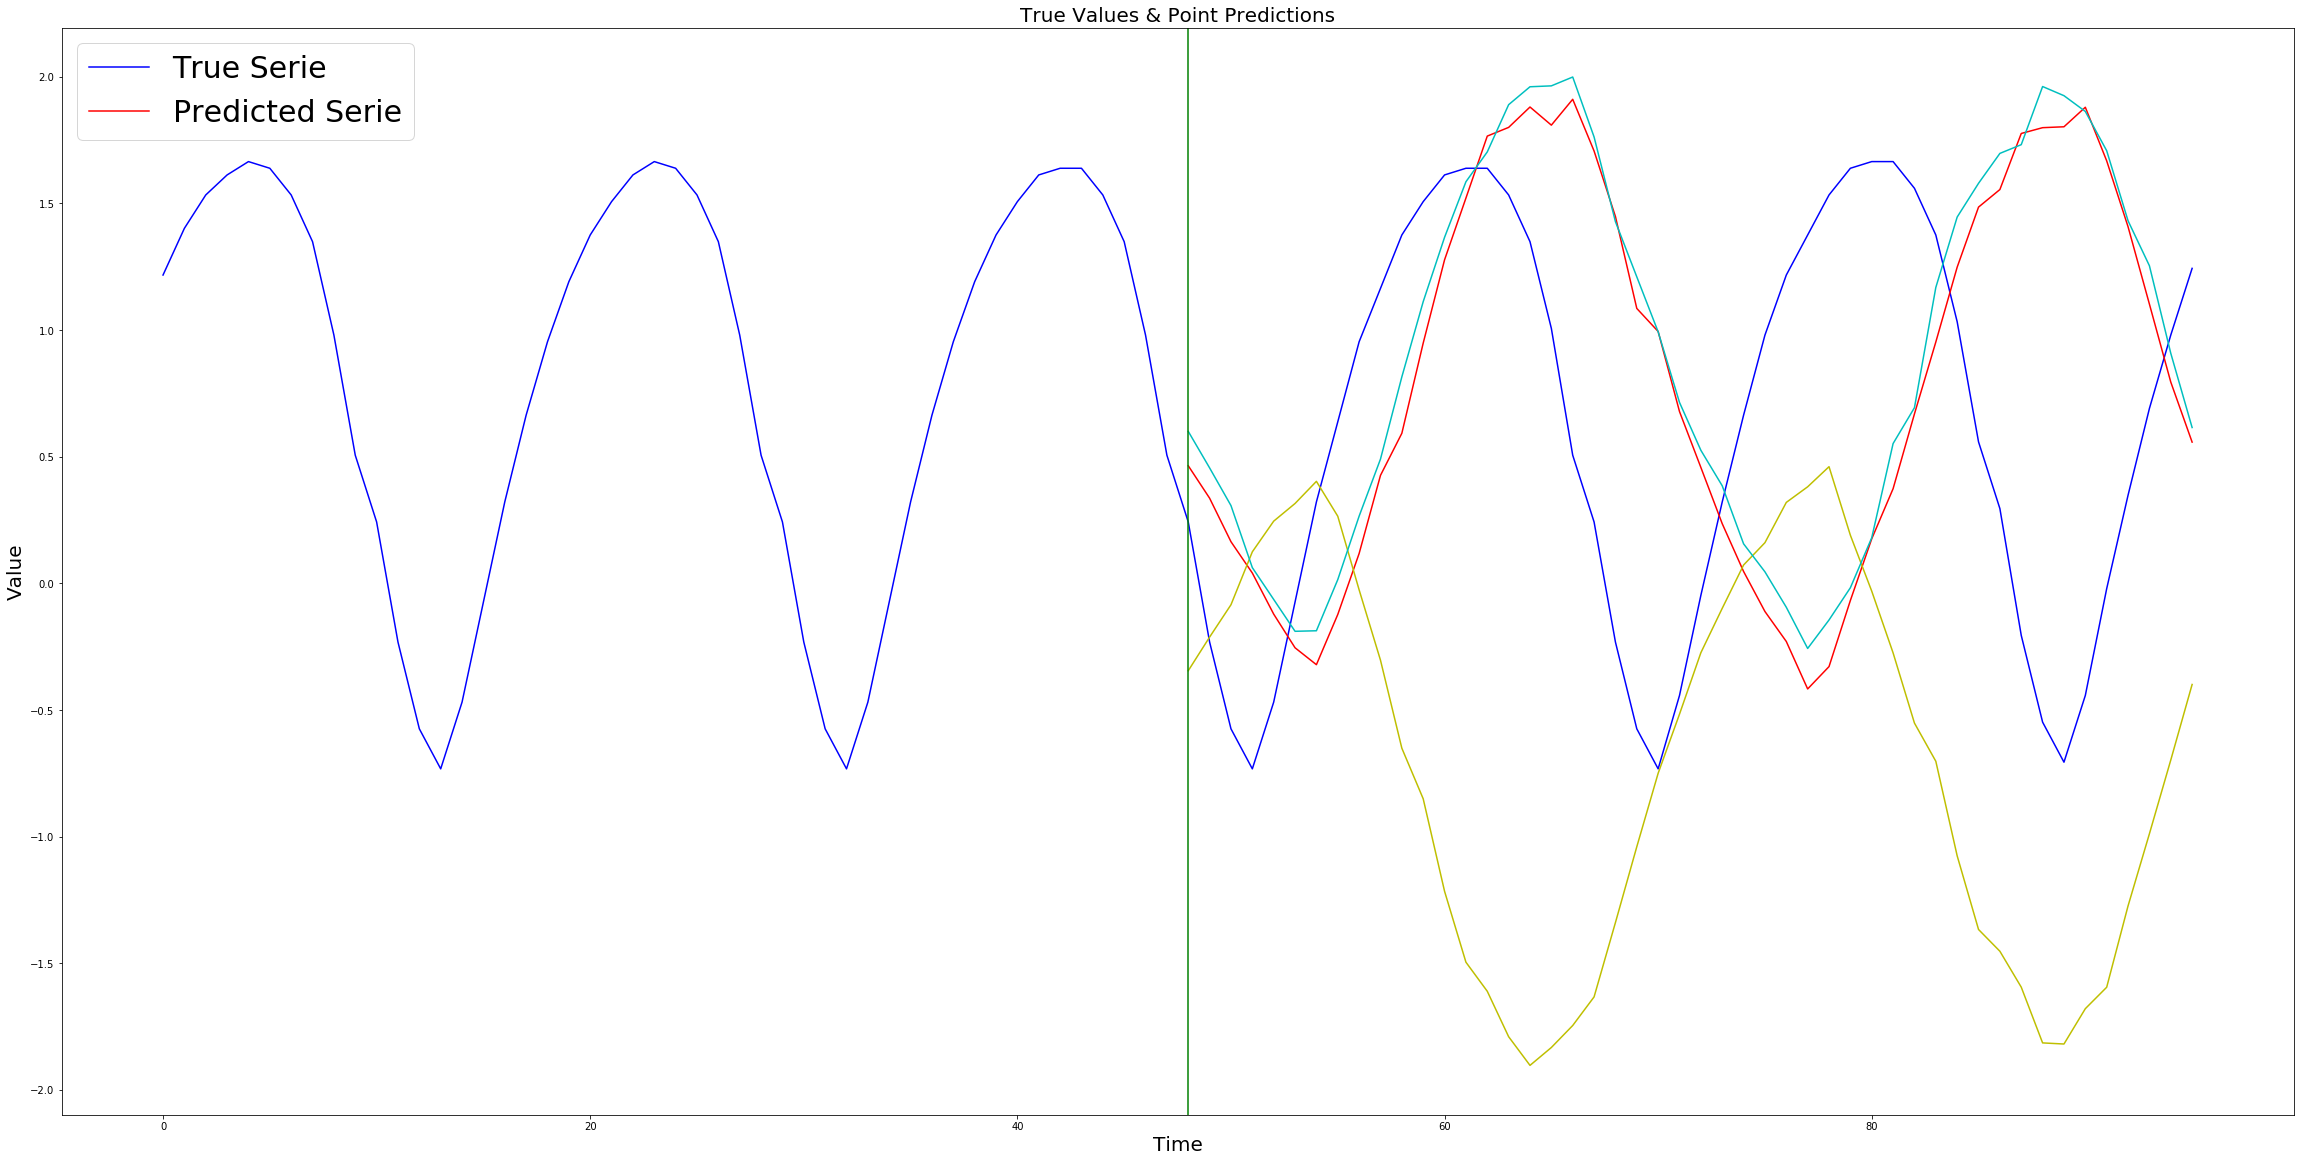

In [5]:
x, y, prediction, error =  sort_by_prediction_error(model, test_x, test_y, smape, features_number= FEATUERS_NUMBER)

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

lower_bound= prediction[:,48*2:48*3]
upper_bound= prediction[:,48*3:]
predicted_values = prediction[:,:48]

plot_serie_and_prediction(x[:,:48], y[:,:48], predicted_values , lower_bound=lower_bound ,upper_bound=upper_bound, serie_indx=0)
plot_serie_and_prediction(x[:,:48], y[:,:48], predicted_values , lower_bound=lower_bound ,upper_bound=upper_bound, serie_indx= x.shape[0]-1)

# PLot Specific Serie From A Batch

TypeError: list indices must be integers or slices, not tuple

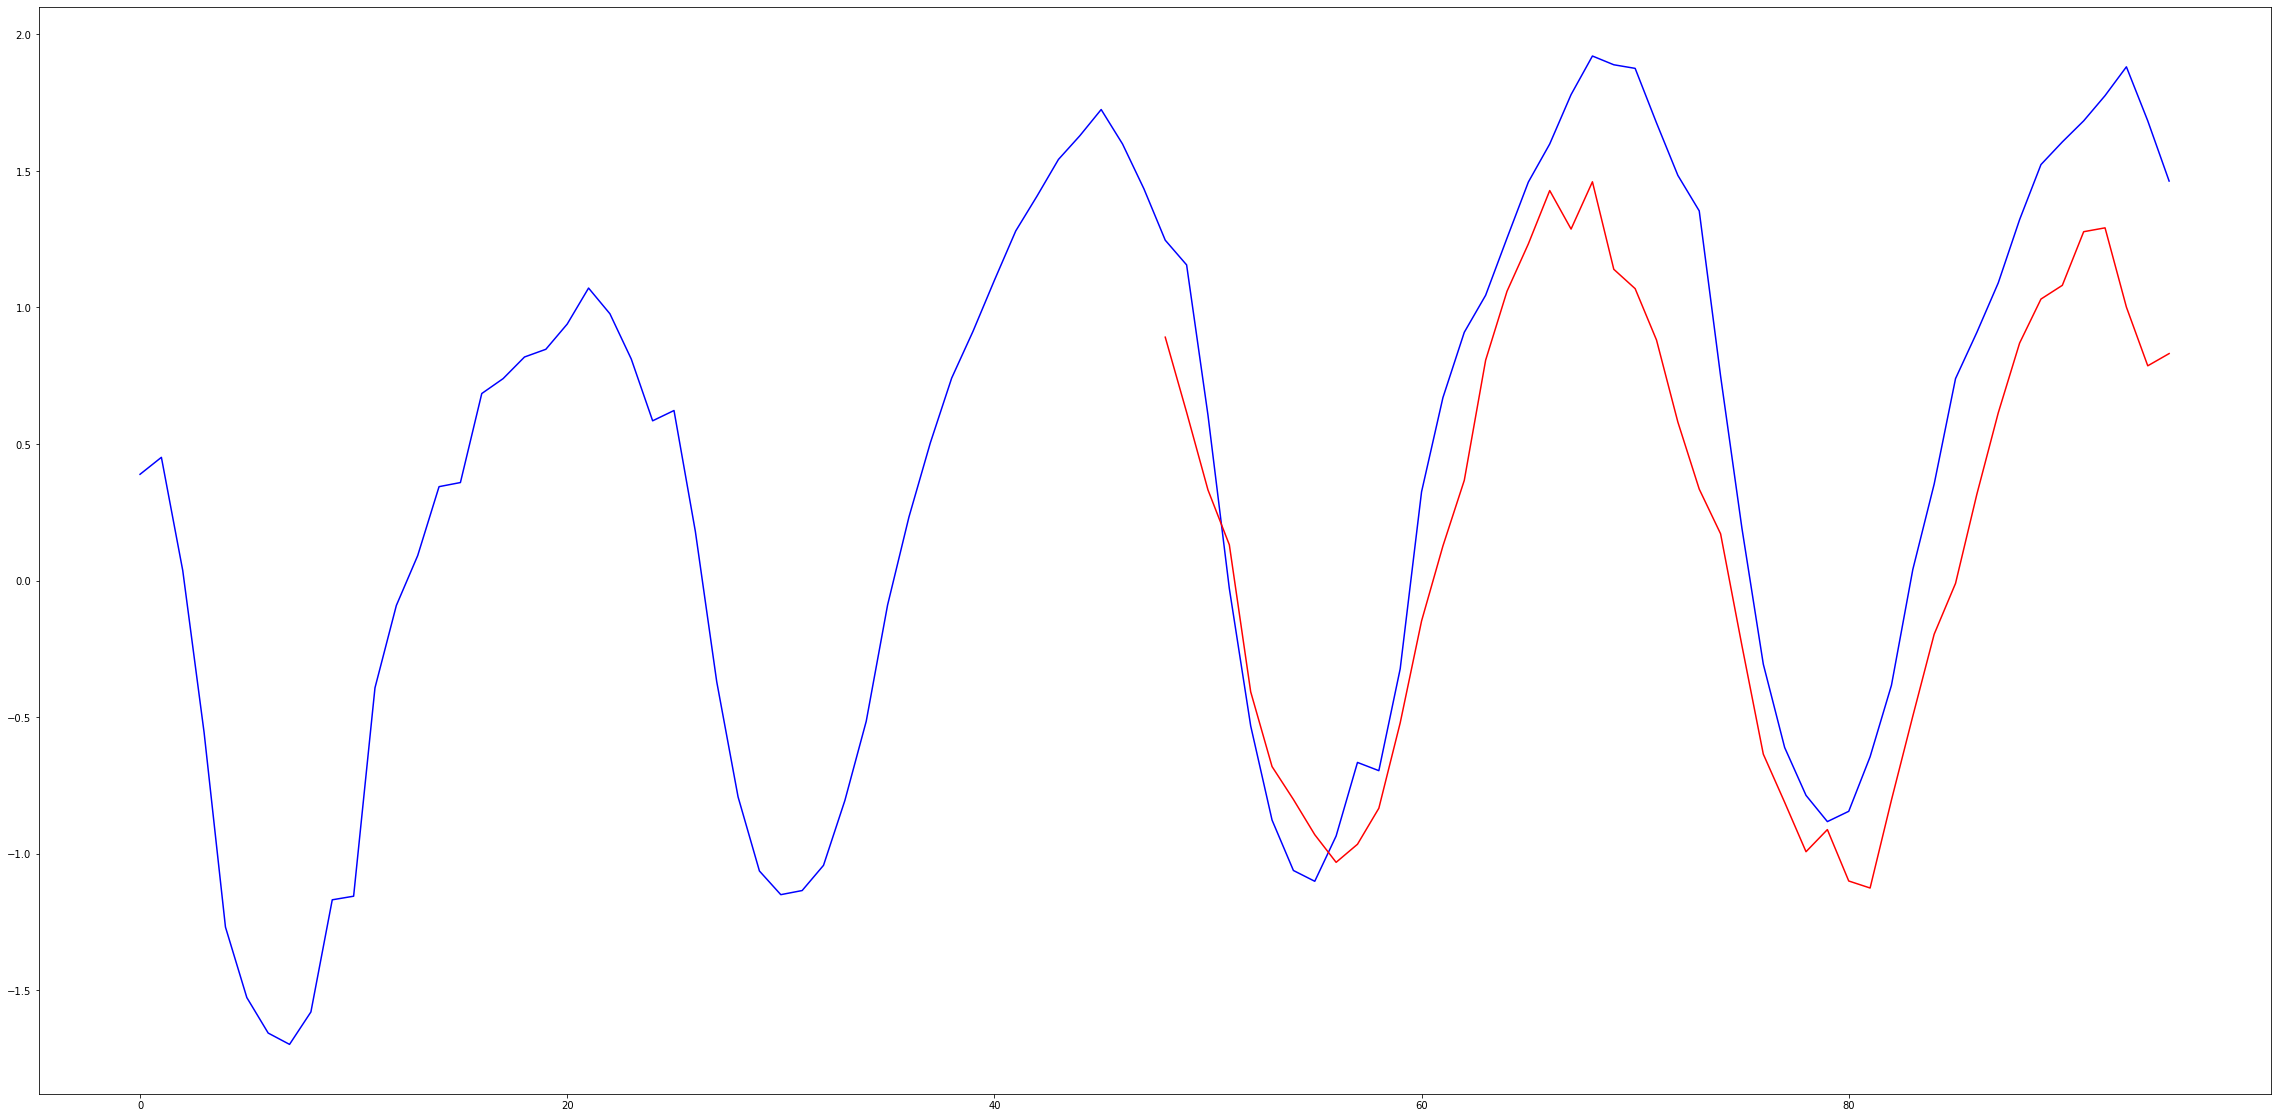

In [6]:
IDX = 40
x = test_x[:BATCH_SIZE,:,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [12]:
MODEL_NUMBER = 2
MODEL_BASE_DIR = '../models/with_lower_upper/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', LOSS)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

FileNotFoundError: [Errno 2] No such file or directory: '../models/with_lower_upper/3-LSTM/3/architecture.json'